# Heart Failure Clinical Records Dataset - Lab 5

## MinMax Normalization

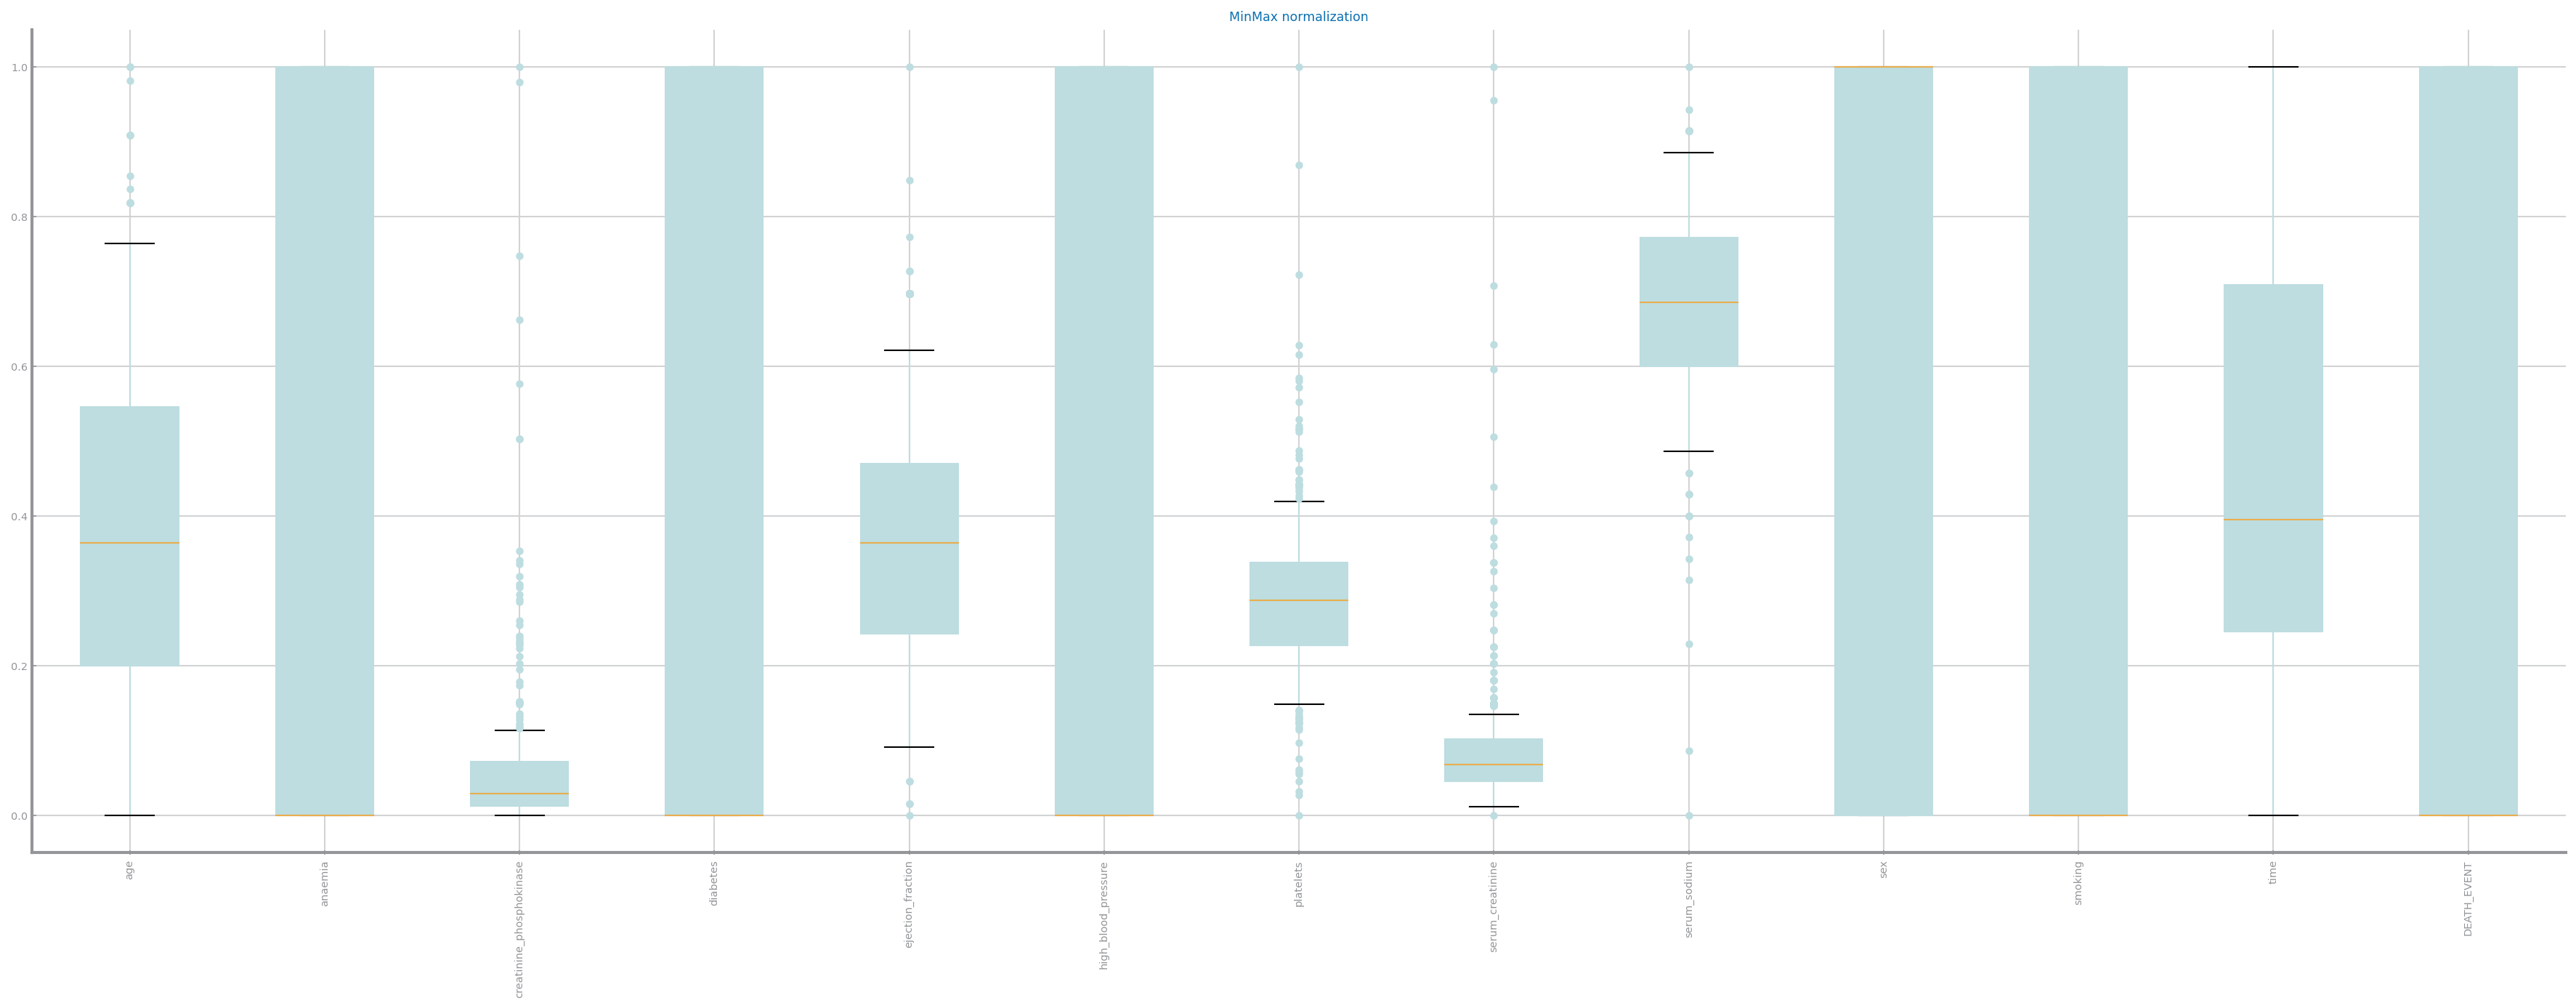

In [1]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ds_functions as ds
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, validation_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_regression, chi2, f_classif, f_regression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import *
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import chisquare
import sklearn.metrics as metrics
from imblearn.over_sampling import SMOTE
from numpy import percentile
from subprocess import call

data: pd.DataFrame = pd.read_csv('datasets/heart_failure_clinical_records_dataset.csv')
original_data = copy.deepcopy(data)

transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(data)
df_nr = pd.DataFrame(transf.transform(data), columns= data.columns)
norm_data_minmax = df_nr
norm_data_minmax.describe(include='all')

fig, axs = plt.subplots(1, 1, figsize=(30,10),squeeze=False )
axs[0, 0].set_title('MinMax normalization')
# axs[0, 2].xticks(rotation=90)
norm_data_minmax.boxplot(ax=axs[0, 0])
# fig.tight_layout()
plt.setp(axs[0, 0].xaxis.get_majorticklabels(), rotation=90)

plt.show()

In [2]:
data_columns = data.columns
data_columns = data_columns.drop("DEATH_EVENT")

## Balancing - Dataset Size

In [3]:
target = 'DEATH_EVENT'

In [4]:
'''
target_count = original_data[target].value_counts()
plt.figure()
plt.title('Class balance')
plt.bar(target_count.index, target_count.values)
plt.show()

min_class = target_count.idxmin()
ind_min_class = target_count.index.get_loc(min_class)

print('Minority class:', target_count[ind_min_class])
print('Majority class:', target_count[1-ind_min_class])
print('Proportion:', round(target_count[ind_min_class] / target_count[1-ind_min_class], 2), ': 1')
'''

"\ntarget_count = original_data[target].value_counts()\nplt.figure()\nplt.title('Class balance')\nplt.bar(target_count.index, target_count.values)\nplt.show()\n\nmin_class = target_count.idxmin()\nind_min_class = target_count.index.get_loc(min_class)\n\nprint('Minority class:', target_count[ind_min_class])\nprint('Majority class:', target_count[1-ind_min_class])\nprint('Proportion:', round(target_count[ind_min_class] / target_count[1-ind_min_class], 2), ': 1')\n"

In [5]:
'''
RANDOM_STATE = 42
values = {'Original': [target_count.values[ind_min_class], target_count.values[1-ind_min_class]]}

df_class_min = original_data[original_data[target] == min_class]
df_class_max = original_data[original_data[target] != min_class]

df_under = df_class_max.sample(len(df_class_min))
values['UnderSample'] = [target_count.values[ind_min_class], len(df_under)]
df_over = df_class_min.sample(len(df_class_max), replace=True)
values['OverSample'] = [len(df_over), target_count.values[1-ind_min_class]]
smote = SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE)
y = original_data.pop(target).values
X = original_data.values
smote_X, smote_y = smote.fit_sample(X, y)
smote_target_count = pd.Series(smote_y).value_counts()
values['SMOTE'] = [smote_target_count.values[ind_min_class], smote_target_count.values[1-ind_min_class]]

fig = plt.figure()
ds.multiple_bar_chart([target_count.index[ind_min_class], target_count.index[1-ind_min_class]], values,
                      title='Target', xlabel='frequency', ylabel='Class balance')
plt.show()
'''

"\nRANDOM_STATE = 42\nvalues = {'Original': [target_count.values[ind_min_class], target_count.values[1-ind_min_class]]}\n\ndf_class_min = original_data[original_data[target] == min_class]\ndf_class_max = original_data[original_data[target] != min_class]\n\ndf_under = df_class_max.sample(len(df_class_min))\nvalues['UnderSample'] = [target_count.values[ind_min_class], len(df_under)]\ndf_over = df_class_min.sample(len(df_class_max), replace=True)\nvalues['OverSample'] = [len(df_over), target_count.values[1-ind_min_class]]\nsmote = SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE)\ny = original_data.pop(target).values\nX = original_data.values\nsmote_X, smote_y = smote.fit_sample(X, y)\nsmote_target_count = pd.Series(smote_y).value_counts()\nvalues['SMOTE'] = [smote_target_count.values[ind_min_class], smote_target_count.values[1-ind_min_class]]\n\nfig = plt.figure()\nds.multiple_bar_chart([target_count.index[ind_min_class], target_count.index[1-ind_min_class]], values,\n      

## Unbalanced Classification

{ 299 , 299 }


<Figure size 600x450 with 0 Axes>

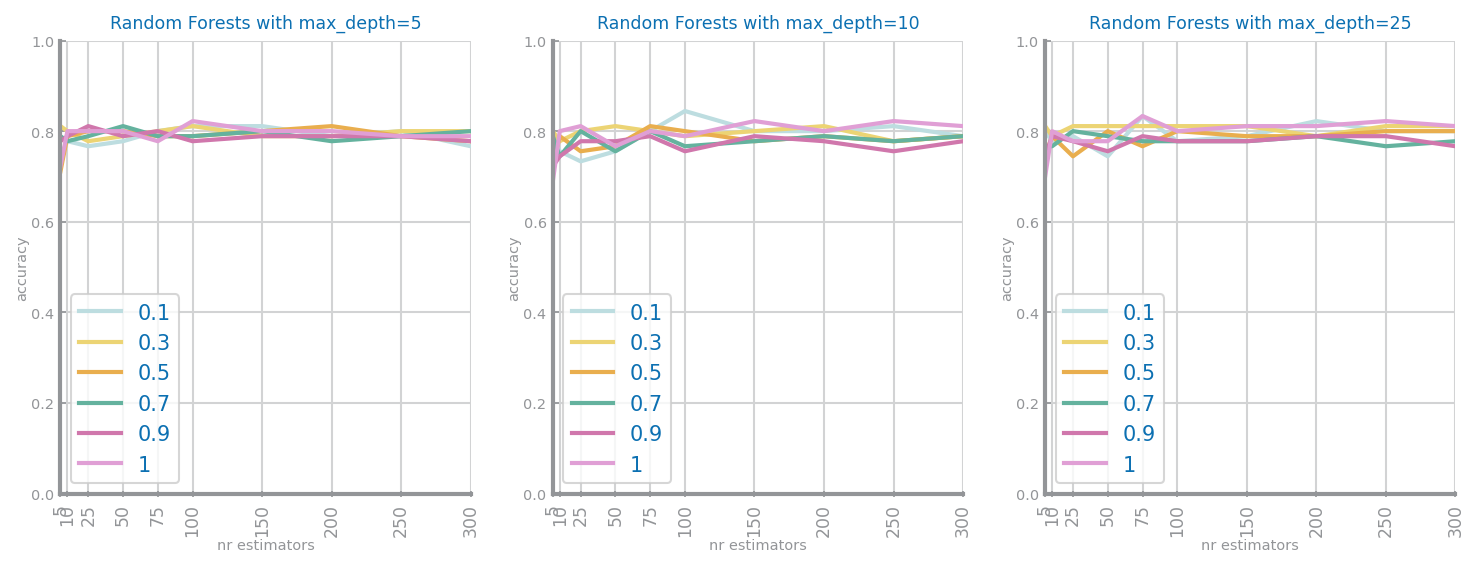

Best results with depth=10, 0.10 features and 100 estimators, with accuracy=0.84
Confusion Matrix Test
TruePositives:  19
FalsePositives:  4
TrueNegatives:  57
FalseNegatives:  10


{'accuracy': 0.8444444444444444,
 'recall': 0.9344262295081968,
 'specificity': 0.6551724137931034,
 'precision': 0.8507462686567164}

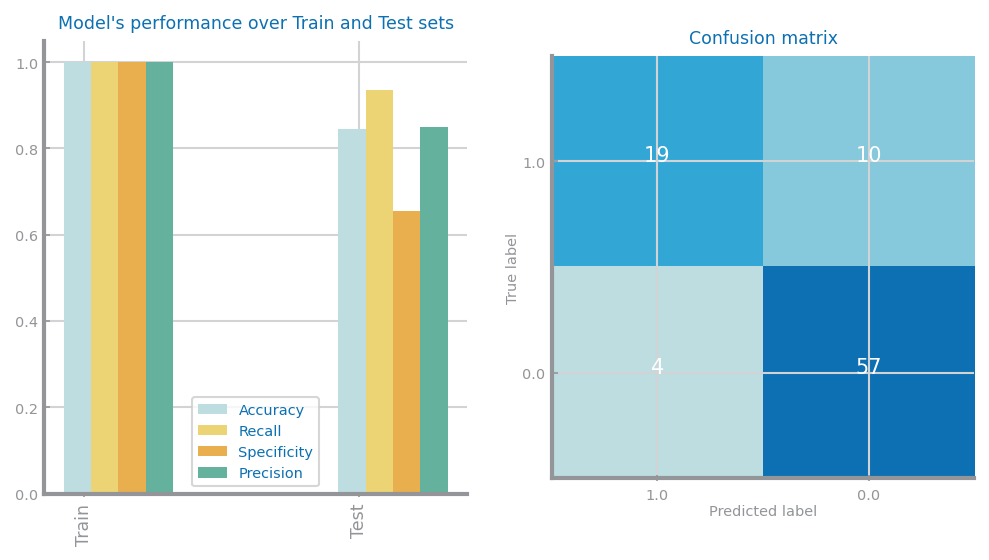

In [4]:
y: np.ndarray = norm_data_minmax.pop(target).values
X: np.ndarray = norm_data_minmax.values

labels = pd.unique(y)
print('{',len(X),',',len(y),'}')
trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

n_estimators = [5, 10, 25, 50, 75, 100, 150, 200, 250, 300]
max_depths = [5, 10, 25]
max_features = [.1, .3, .5, .7, .9, 1]
best = ('', 0, 0)
last_best = 0
best_tree = None

cols = len(max_depths)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    for f in max_features:
        yvalues = []
        for n in n_estimators:
            rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
            rf.fit(trnX, trnY)
            prdY = rf.predict(tstX)
            yvalues.append(metrics.accuracy_score(tstY, prdY))
            if yvalues[-1] > last_best:
                best = (d, f, n)
                last_best = yvalues[-1]
                best_tree = rf

        values[f] = yvalues
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Random Forests with max_depth=%d'%d,
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)

plt.show()
print('Best results with depth=%d, %1.2f features and %d estimators, with accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

prd_trn = best_tree.predict(trnX)
prd_tst = best_tree.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)

## Over Sampled Classification

In [7]:
'''
over_sampled = pd.concat([df_over,df_class_max])
y: np.ndarray = over_sampled.pop(target).values
X: np.ndarray = over_sampled.values
labels: np.ndarray = pd.unique(y)

print('{',len(X),',',len(y),'}')
trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

n_estimators = [5, 10, 25, 50, 75, 100, 150, 200, 250, 300]
max_depths = [5, 10, 25]
max_features = [.1, .3, .5, .7, .9, 1]
best = ('', 0, 0)
last_best = 0
best_tree = None

cols = len(max_depths)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    for f in max_features:
        yvalues = []
        for n in n_estimators:
            rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
            rf.fit(trnX, trnY)
            prdY = rf.predict(tstX)
            yvalues.append(metrics.accuracy_score(tstY, prdY))
            if yvalues[-1] > last_best:
                best = (d, f, n)
                last_best = yvalues[-1]
                best_tree = rf

        values[f] = yvalues
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Random Forests with max_depth=%d'%d,
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)

plt.show()
print('Best results with depth=%d, %1.2f features and %d estimators, with accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

prd_trn = best_tree.predict(trnX)
prd_tst = best_tree.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)
'''

"\nover_sampled = pd.concat([df_over,df_class_max])\ny: np.ndarray = over_sampled.pop(target).values\nX: np.ndarray = over_sampled.values\nlabels: np.ndarray = pd.unique(y)\n\nprint('{',len(X),',',len(y),'}')\ntrnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)\n\nn_estimators = [5, 10, 25, 50, 75, 100, 150, 200, 250, 300]\nmax_depths = [5, 10, 25]\nmax_features = [.1, .3, .5, .7, .9, 1]\nbest = ('', 0, 0)\nlast_best = 0\nbest_tree = None\n\ncols = len(max_depths)\nplt.figure()\nfig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)\nfor k in range(len(max_depths)):\n    d = max_depths[k]\n    values = {}\n    for f in max_features:\n        yvalues = []\n        for n in n_estimators:\n            rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)\n            rf.fit(trnX, trnY)\n            prdY = rf.predict(tstX)\n            yvalues.append(metrics.accuracy_score(tstY, prdY))\n            if yvalues[-1] > la

## Under Sampled Classification

In [8]:
'''
under_sampled = pd.concat([df_under,df_class_min])
y: np.ndarray = under_sampled.pop(target).values
X: np.ndarray = under_sampled.values
labels: np.ndarray = pd.unique(y)

print('{',len(X),',',len(y),'}')
trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

n_estimators = [5, 10, 25, 50, 75, 100, 150, 200, 250, 300]
max_depths = [5, 10, 25]
max_features = [.1, .3, .5, .7, .9, 1]
best = ('', 0, 0)
last_best = 0
best_tree = None

cols = len(max_depths)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    for f in max_features:
        yvalues = []
        for n in n_estimators:
            rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
            rf.fit(trnX, trnY)
            prdY = rf.predict(tstX)
            yvalues.append(metrics.accuracy_score(tstY, prdY))
            if yvalues[-1] > last_best:
                best = (d, f, n)
                last_best = yvalues[-1]
                best_tree = rf

        values[f] = yvalues
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Random Forests with max_depth=%d'%d,
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)

plt.show()
print('Best results with depth=%d, %1.2f features and %d estimators, with accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

prd_trn = best_tree.predict(trnX)
prd_tst = best_tree.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)
'''

"\nunder_sampled = pd.concat([df_under,df_class_min])\ny: np.ndarray = under_sampled.pop(target).values\nX: np.ndarray = under_sampled.values\nlabels: np.ndarray = pd.unique(y)\n\nprint('{',len(X),',',len(y),'}')\ntrnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)\n\nn_estimators = [5, 10, 25, 50, 75, 100, 150, 200, 250, 300]\nmax_depths = [5, 10, 25]\nmax_features = [.1, .3, .5, .7, .9, 1]\nbest = ('', 0, 0)\nlast_best = 0\nbest_tree = None\n\ncols = len(max_depths)\nplt.figure()\nfig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)\nfor k in range(len(max_depths)):\n    d = max_depths[k]\n    values = {}\n    for f in max_features:\n        yvalues = []\n        for n in n_estimators:\n            rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)\n            rf.fit(trnX, trnY)\n            prdY = rf.predict(tstX)\n            yvalues.append(metrics.accuracy_score(tstY, prdY))\n            if yvalues[-1] 

## SMOTE Classification

In [9]:
'''
y = smote_y
X = smote_X
labels = pd.unique(y)
    
print('{',len(X),',',len(y),'}')
trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

n_estimators = [5, 10, 25, 50, 75, 100, 150, 200, 250, 300]
max_depths = [5, 10, 25]
max_features = [.1, .3, .5, .7, .9, 1]
best = ('', 0, 0)
last_best = 0
best_tree = None

cols = len(max_depths)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    for f in max_features:
        yvalues = []
        for n in n_estimators:
            rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
            rf.fit(trnX, trnY)
            prdY = rf.predict(tstX)
            yvalues.append(metrics.accuracy_score(tstY, prdY))
            if yvalues[-1] > last_best:
                best = (d, f, n)
                last_best = yvalues[-1]
                best_tree = rf

        values[f] = yvalues
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Random Forests with max_depth=%d'%d,
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)

plt.show()
print('Best results with depth=%d, %1.2f features and %d estimators, with accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

prd_trn = best_tree.predict(trnX)
prd_tst = best_tree.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)
'''

"\ny = smote_y\nX = smote_X\nlabels = pd.unique(y)\n    \nprint('{',len(X),',',len(y),'}')\ntrnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)\n\nn_estimators = [5, 10, 25, 50, 75, 100, 150, 200, 250, 300]\nmax_depths = [5, 10, 25]\nmax_features = [.1, .3, .5, .7, .9, 1]\nbest = ('', 0, 0)\nlast_best = 0\nbest_tree = None\n\ncols = len(max_depths)\nplt.figure()\nfig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)\nfor k in range(len(max_depths)):\n    d = max_depths[k]\n    values = {}\n    for f in max_features:\n        yvalues = []\n        for n in n_estimators:\n            rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)\n            rf.fit(trnX, trnY)\n            prdY = rf.predict(tstX)\n            yvalues.append(metrics.accuracy_score(tstY, prdY))\n            if yvalues[-1] > last_best:\n                best = (d, f, n)\n                last_best = yvalues[-1]\n                best_tree = rf\n\

# Feature Selection

Numerical input, Categorical output => ANOVA (linear correlation), Kendall (non-linear correlation)

**ANOVA**

In [5]:
def select_features_numerical(X, y, technique, selection):
    if technique == "pearson":
        scoref = f_regression
    elif technique == "anova":
        scoref = f_classif
    
    if selection == "kbest":
        fs = SelectKBest(score_func=scoref, k=9)
    elif selection == "percentile":
        fs = SelectPercentile(score_func=scoref, percentile=85)
    
    X_selected = fs.fit_transform(X, y)
    #print(X_selected.shape)
    return train_test_split(X_selected, y, train_size=0.7, stratify=y)

In [6]:
X_anova_kbest = select_features_numerical_anova(X, y, "kbest")
X_anova_percentile = select_features_numerical_anova(X, y, "percentile")

**Kendall**

In [31]:
'''
X_kendall = X.copy()

# creating set to hold the correlated features
corr_features = set()

# create the correlation matrix (default to pearson)
corr_matrix = X_kendall.corr()

# optional: display a heatmap of the correlation matrix
plt.figure(figsize=(11,11))
sns.heatmap(corr_matrix)

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            colname = corr_matrix.columns[i]
            corr_features.add(colname)
            
X_kendall.drop(labels=corr_features, axis=1, inplace=True)
X_kendall
'''

AttributeError: 'numpy.ndarray' object has no attribute 'corr'

In [11]:
#df_over.var()

In [80]:
abs(data.corr()["DEATH_EVENT"])

age                         0.253729
anaemia                     0.066270
creatinine_phosphokinase    0.062728
diabetes                    0.001943
ejection_fraction           0.268603
high_blood_pressure         0.079351
platelets                   0.049139
serum_creatinine            0.294278
serum_sodium                0.195204
sex                         0.004316
smoking                     0.012623
time                        0.526964
DEATH_EVENT                 1.000000
Name: DEATH_EVENT, dtype: float64

In [17]:
clf = GaussianNB()
cv = KFold(n_splits=10, random_state=40, shuffle=False)
sfs1 = SFS(clf, k_features=12, forward=True, scoring='accuracy', cv=cv)
sfs1.fit(X,y)
sfs1.subsets_

{1: {'feature_idx': (11,),
  'cv_scores': array([0.9 , 0.83, 0.43, 0.3 , 0.83, 0.83, 0.7 , 0.87, 0.9 , 1.  ]),
  'avg_score': 0.76,
  'feature_names': ('11',)},
 2: {'feature_idx': (8, 11),
  'cv_scores': array([0.9 , 0.73, 0.73, 0.73, 0.8 , 0.83, 0.67, 0.87, 0.9 , 1.  ]),
  'avg_score': 0.8166666666666667,
  'feature_names': ('8', '11')},
 3: {'feature_idx': (1, 8, 11),
  'cv_scores': array([0.9 , 0.77, 0.77, 0.7 , 0.8 , 0.83, 0.67, 0.87, 0.9 , 1.  ]),
  'avg_score': 0.8200000000000001,
  'feature_names': ('1', '8', '11')},
 4: {'feature_idx': (1, 8, 10, 11),
  'cv_scores': array([0.87, 0.77, 0.77, 0.67, 0.8 , 0.83, 0.67, 0.87, 0.9 , 1.  ]),
  'avg_score': 0.8133333333333332,
  'feature_names': ('1', '8', '10', '11')},
 5: {'feature_idx': (1, 4, 8, 10, 11),
  'cv_scores': array([0.83, 0.67, 0.87, 0.7 , 0.77, 0.83, 0.67, 0.87, 0.9 , 1.  ]),
  'avg_score': 0.8099999999999999,
  'feature_names': ('1', '4', '8', '10', '11')},
 6: {'feature_idx': (0, 1, 4, 8, 10, 11),
  'cv_scores': array(

Feature 0: age
Feature 1: anaemia
Feature 2: creatinine_phosphokinase
Feature 4: ejection_fraction
Feature 7: serum_creatinine
Feature 11: time

In [16]:
lr = LogisticRegression()
cv = KFold(n_splits=10, random_state=40, shuffle=False)
sfs1 = SFS(lr, k_features=1, forward=False, scoring='accuracy', cv=cv)
sfs1.fit(X,y)
sfs1.subsets_

{12: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11),
  'cv_scores': array([0.7 , 0.57, 0.8 , 0.7 , 0.8 , 0.83, 0.7 , 0.87, 0.9 , 1.  ]),
  'avg_score': 0.7866666666666667,
  'feature_names': ('0',
   '1',
   '2',
   '3',
   '4',
   '5',
   '6',
   '7',
   '8',
   '9',
   '10',
   '11')},
 11: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11),
  'cv_scores': array([0.7 , 0.57, 0.8 , 0.83, 0.8 , 0.83, 0.7 , 0.87, 0.9 , 1.  ]),
  'avg_score': 0.8,
  'feature_names': ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '11')},
 10: {'feature_idx': (0, 1, 2, 4, 5, 6, 7, 8, 9, 11),
  'cv_scores': array([0.73, 0.6 , 0.77, 0.8 , 0.8 , 0.83, 0.7 , 0.87, 0.9 , 1.  ]),
  'avg_score': 0.8,
  'feature_names': ('0', '1', '2', '4', '5', '6', '7', '8', '9', '11')},
 9: {'feature_idx': (1, 2, 4, 5, 6, 7, 8, 9, 11),
  'cv_scores': array([0.7 , 0.67, 0.83, 0.77, 0.83, 0.83, 0.7 , 0.87, 0.9 , 1.  ]),
  'avg_score': 0.8100000000000002,
  'feature_names': ('1', '2', '4', '5', '6', '7', '8', '9', '11'

Feature 0: age
Feature 1: anaemia
Feature 2: creatinine_phosphokinase
Feature 4: ejection_fraction
Feature 7: serum_creatinine
Feature 11: time

In [18]:
# define feature selection
fs = SelectKBest(score_func=f_regression, k=10)
# apply feature selection
X_selected = fs.fit_transform(X, y)
print(X_selected.shape)


(299, 9)


In [19]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=9)
fit = bestfeatures.fit(X, y)

In [20]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(data_columns)

In [21]:
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']

Feature 0: 32.775360 age
Feature 1: 1.722905 anaemia
Feature 2: 1071.332709 creatinine_phosphokinase
Feature 3: 0.018824 diabetes
Feature 4: 93.100579 ejection_fraction
Feature 5: 0.874281 high_blood_pressure
Feature 6: 4.504709 platelets
Feature 7: 22.404972 serum_creatinine
Feature 8: 0.505677 serum_sodium
Feature 9: 0.011472 sex


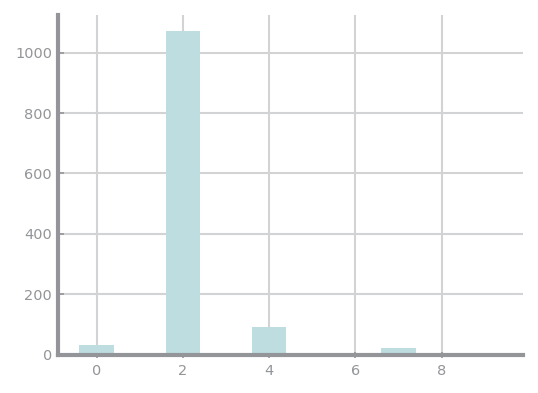

In [87]:
'''
def select_features_chi2(X_train, y_train, X_test):
    fs = SelectKBest(score_func=chi2, k='all')
        fs.fit(X_train, y_train)
            X_train_fs = fs.transform(X_train)
                X_test_fs = fs.transform(X_test)
                    return X_train_fs, X_test_fs, fs

                    trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)
                    X_train_fs, X_test_fs, fs = select_features_chi2(trnX, trnY, tstX)
,'Score'))  #print 10 best features
def select_features_chi2(X_train, y_train, X_test):
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)
X_train_fs, X_test_fs, fs = select_features_chi2(trnX, trnY, tstX)

for i in range(10):
    print('Feature %d: %f %s' % (i, fs.scores_[i], data_columns[i]))  # Scores for the features

plt.bar([i for i in range(10)], fs.scores_[:10])
plt.show()
'''

In [22]:
featureScores

,Specs,Score
0,age,2.368846
1,anaemia,0.746593
2,creatinine_phosphokinase,0.252029
3,diabetes,0.000657
4,ejection_fraction,1.894516
5,high_blood_pressure,1.221539
6,platelets,0.035021
7,serum_creatinine,3.471610
8,serum_sodium,0.267368
9,sex,0.001956


In [23]:
print(featureScores.nlargest(,'Score'))  #print 10 best features

                       Specs      Score
11                      time  14.050286
7           serum_creatinine   3.471610
0                        age   2.368846
4          ejection_fraction   1.894516
5        high_blood_pressure   1.221539
1                    anaemia   0.746593
8               serum_sodium   0.267368
2   creatinine_phosphokinase   0.252029
6                  platelets   0.035021


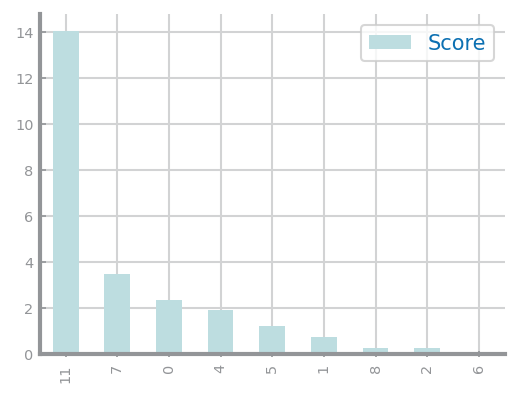

In [25]:
ax = featureScores.nlargest(,'Score').plot.bar()

[0.1  0.02 0.07 0.03 0.13 0.03 0.07 0.12 0.09 0.03 0.03 0.29]


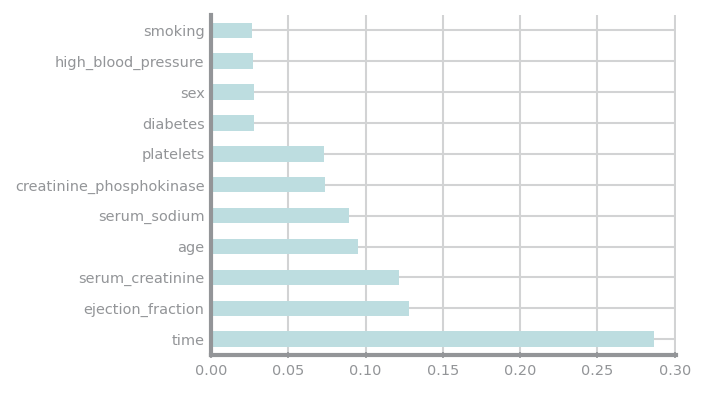

In [27]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, data_columns)
feat_importances.nlargest(11).plot(kind='barh')
plt.show()

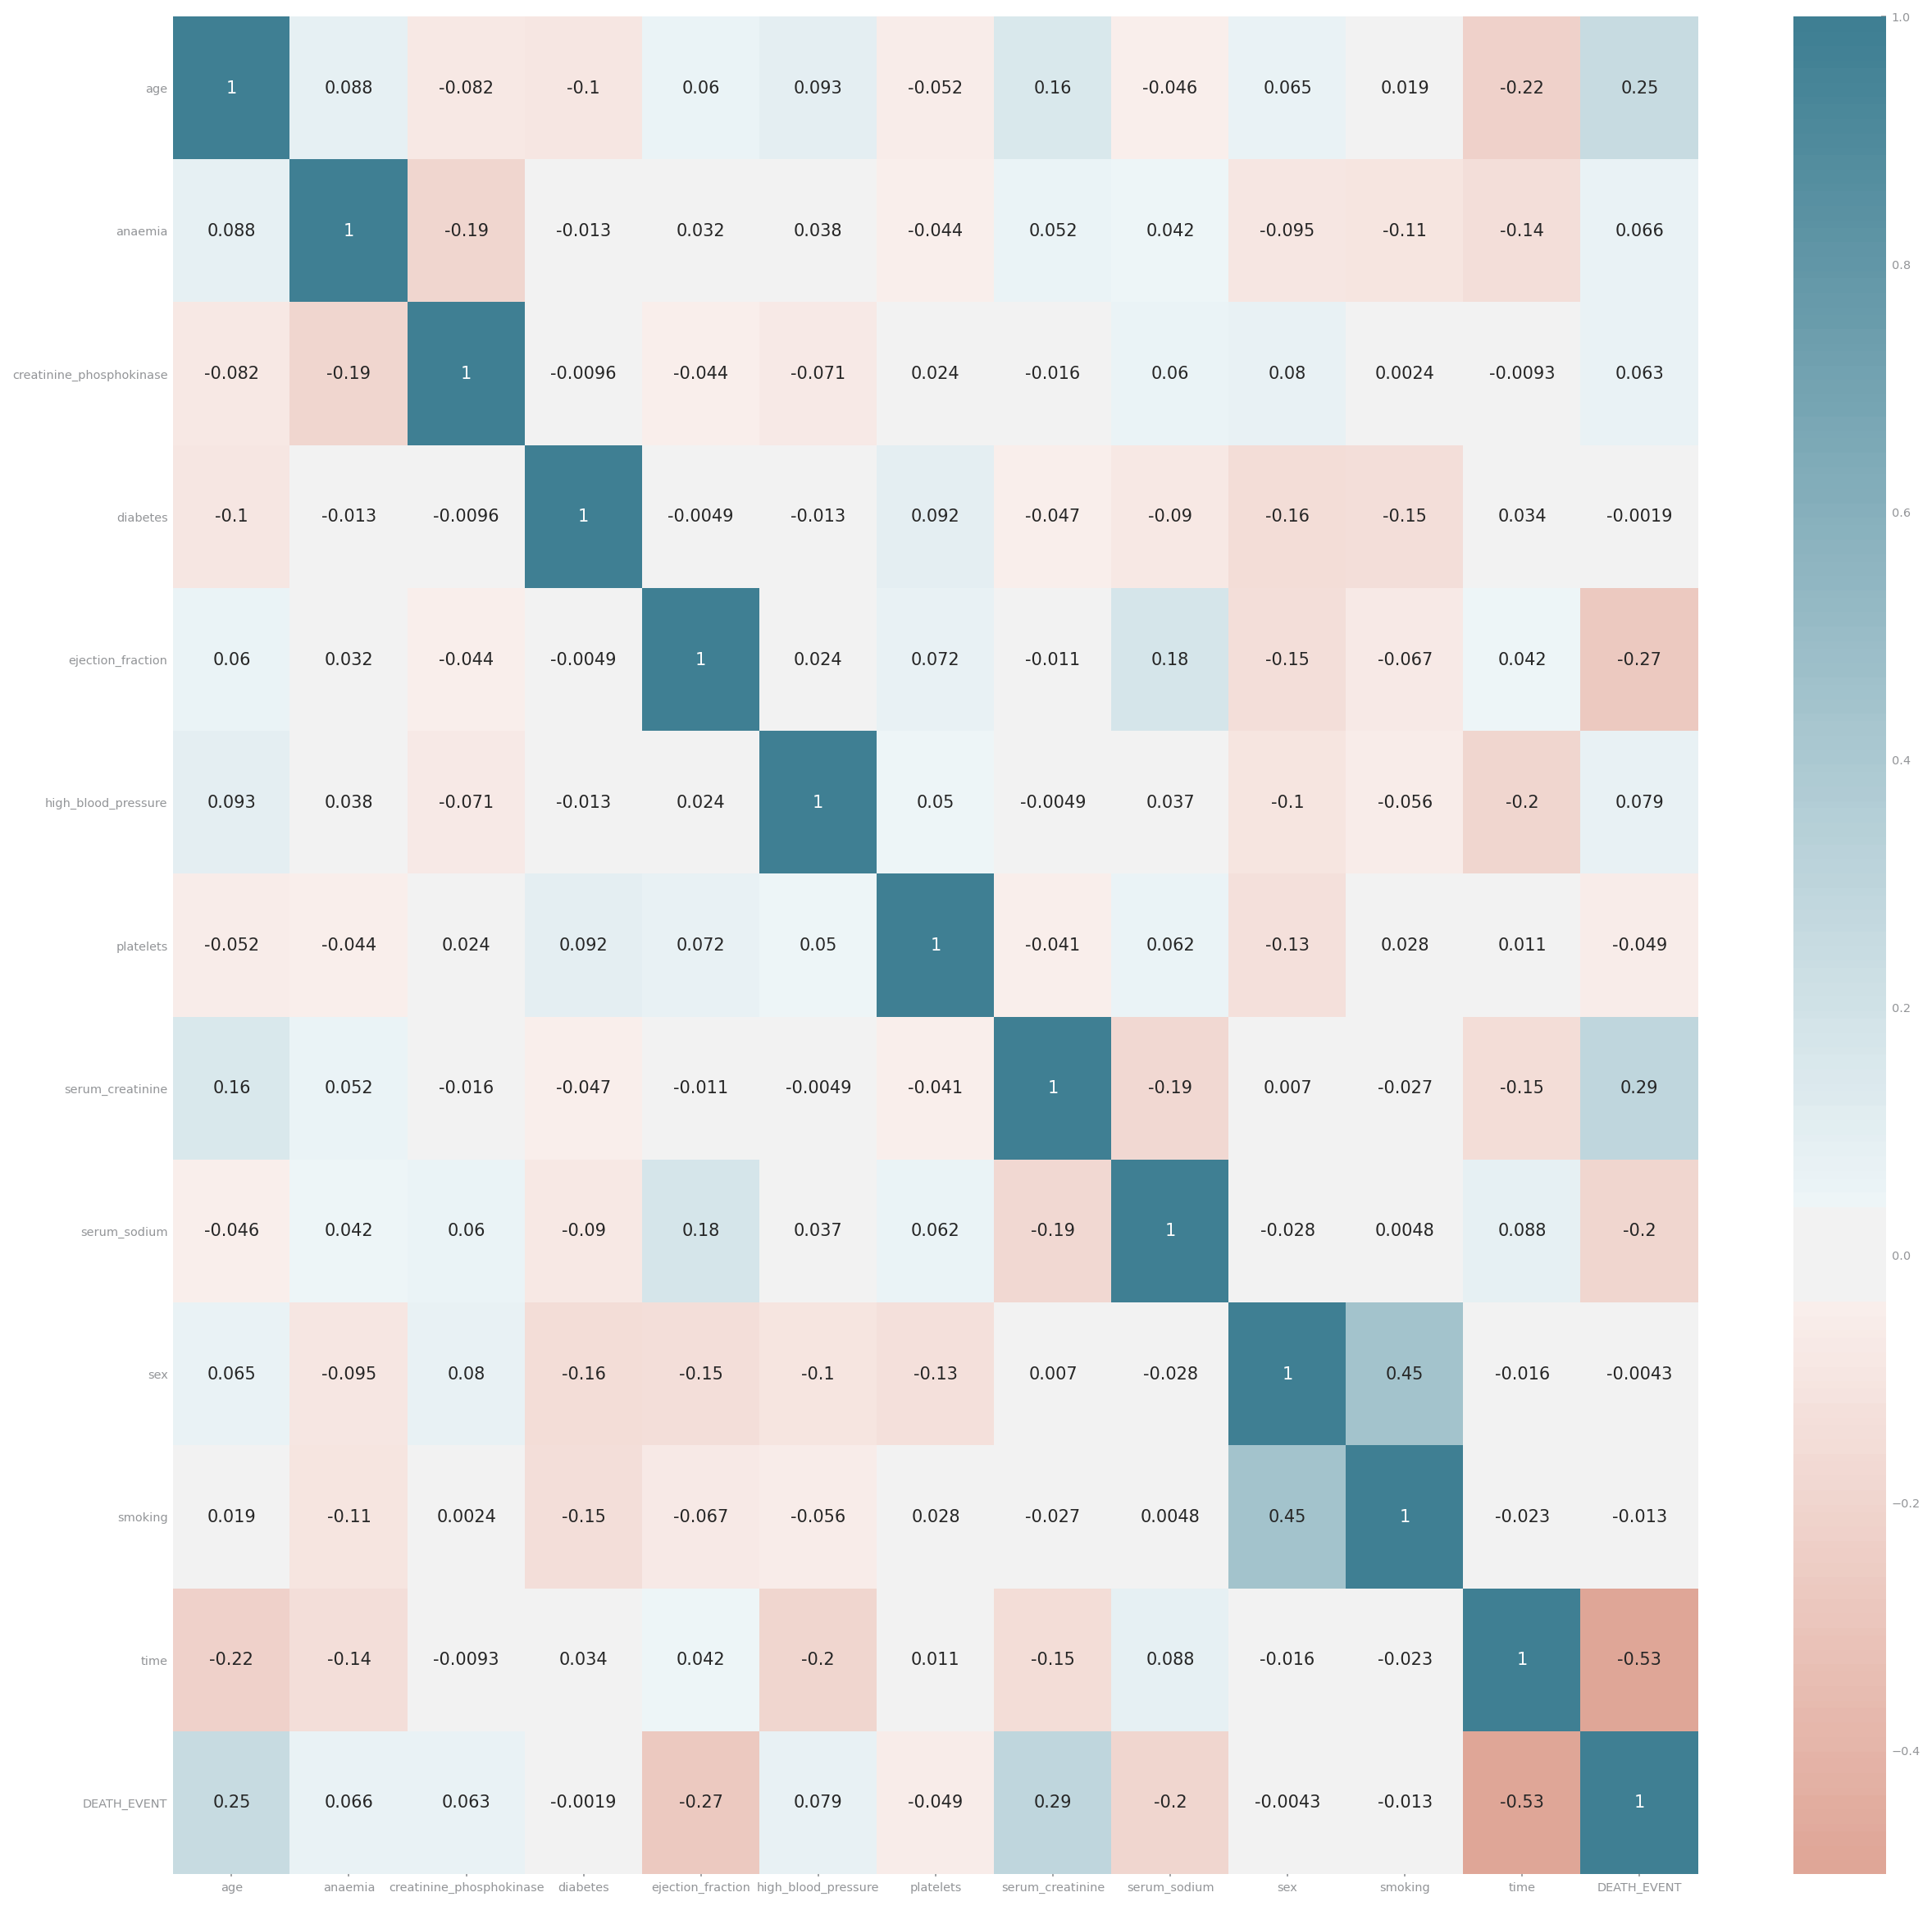

In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
#get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap=sns.diverging_palette(20, 220, n=200),vmin=-0.5, vmax=1, center=0,)

## Classification models after applying Feature Selection

### Naive Bayes

In [41]:
from sklearn.naive_bayes import *

def naive_bayes(trnX, trnY, y):
    labels = pd.unique(y)
    
    clf = MultinomialNB()
    clf.fit(trnX, trnY)
    prd_trn = clf.predict(trnX)
    prd_tst = clf.predict(tstX)
    ds.plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)

* GaussianNB: implements the Gaussian Naive Bayes algorithm for classification, wherein the likelihood of the features is assumed to be Gaussian
* MultinomialNB: implements the naive Bayes algorithm for multinomially distributed data, suitable for classification with discrete features
* BernoulyNB: implements the naive Bayes training and classification algorithms for data that is distributed according to multivariate Bernoulli distributions, ie, there may be multiple features but each one is assumed to be a binary-valued (Bernoulli, boolean) variable
* ComplementNB: implements the complement naive Bayes algorithm, an adaptation of the standard multinomial naive Bayes using statistics from the complement of each class to compute the model’s weights

From the aforementioned described models, it follows that Gaussian algorithm has a higher accuracy since each one of the numeric attributes is normally distributed for each class.

### KNN

In [42]:
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsClassifier

def knn_model(trnX, trnY, tstX, tstY):
    labels = pd.unique(y)

    nvalue = 15
    dist = 'manhattan'
    values = {}
    best = (0, '')
    last_best = 0
    yvalues = []
    knn = KNeighborsClassifier(n_neighbors=nvalue, metric=dist)
    knn.fit(trnX, trnY)
    prd_trn = knn.predict(trnX)
    prd_tst = knn.predict(tstX)
    ds.plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)

### Decision Trees

In [43]:
# Normalized Data se necessário
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [44]:
def remove_outliers(data):
    data_features = data.copy()
    death_event = data_features[['DEATH_EVENT']]
    data_features.pop('DEATH_EVENT')

    rows_to_drop = {}
    id_to_drop=[]
    for var in data_features:
        val_max = data_features[var].max()
        val_min = data_features[var].min()
    #     print(val_max)
    #     print(val_min)
        quartiles = percentile(data_features[var], [25, 50, 75])
    #     print (quartiles)

        iqr = quartiles[2] - quartiles[0]

        lower_val_aceptable = quartiles[0] - 1.5*iqr
        max_val_aceptable = quartiles[2] + 1.5*iqr

    #     print (lower_val_aceptable)
    #     print (max_val_aceptable)


        if val_max > max_val_aceptable or val_min < lower_val_aceptable:
            print(var + " as outliers")
            count=0
            outliers_num = 0
            for ele in data_features[var]:
                if ele > max_val_aceptable or ele < lower_val_aceptable:
                    outliers_num+=1
                    
                    rows_to_drop[str(count)] = rows_to_drop.get(str(count), 0) + 1
                count+=1
            print("Outliers number = ",outliers_num)
            print("Outliers percentage = ",round((outliers_num*100)/len(data_features[var]),3))
            print()
    
    init_len = len(data_features)
    for key, value in rows_to_drop.items():
        if value >=2:
            id_to_drop.append(int(key))
        
    clean_data = data_features.drop(id_to_drop, axis=0)
    clean_data = clean_data.reindex(clean_data.columns, axis=1)
    clean_death_event = death_event.drop(id_to_drop, axis=0)
    clean_death_event = clean_death_event.reindex(clean_death_event.columns, axis=1)
    
    result = pd.concat([clean_data, clean_death_event], axis=1, sort=False)
    
    print("Number of dropped cols: ", init_len - len(clean_data))
    return result

In [98]:
transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(df_nr)
df_nr = pd.DataFrame(transf.transform(df_nr), columns= df_nr.columns)
norm_data_minmax = df_nr.copy()
norm_data_minmax.describe(include='all')

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000
mean,0.378798,0.431438,0.071299,0.418060,0.364903,0.351171,0.288833,0.100436,0.675012,0.648829,0.32107,0.449327
std,0.216269,0.496107,0.123793,0.494067,0.179316,0.478136,0.118565,0.116237,0.126071,0.478136,0.46767,0.276207
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.200000,0.000000,0.011929,0.000000,0.242424,0.000000,0.227179,0.044944,0.600000,0.000000,0.00000,0.245552
50%,0.363636,0.000000,0.028961,0.000000,0.363636,0.000000,0.287186,0.067416,0.685714,1.000000,0.00000,0.395018
75%,0.545455,1.000000,0.071319,1.000000,0.469697,1.000000,0.337495,0.101124,0.771429,1.000000,1.00000,0.708185
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


In [99]:
clean_data = remove_outliers(data)
updated_data = clean_data
updated_data_vars = updated_data.select_dtypes(include='object')
updated_data[updated_data_vars.columns] = updated_data.select_dtypes(['object']).apply(lambda x: x.astype('category'))
transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(updated_data)
df_nr_clean = pd.DataFrame(transf.transform(updated_data), columns= updated_data.columns)

creatinine_phosphokinase as outliers
Outliers number =  29
Outliers percentage =  9.699

ejection_fraction as outliers
Outliers number =  2
Outliers percentage =  0.669

platelets as outliers
Outliers number =  21
Outliers percentage =  7.023

serum_creatinine as outliers
Outliers number =  29
Outliers percentage =  9.699

serum_sodium as outliers
Outliers number =  4
Outliers percentage =  1.338

Number of dropped cols:  10


In [100]:
transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(df_nr_clean)
df_nr_clean = pd.DataFrame(transf.transform(updated_data), columns= updated_data.columns)
norm_data_minmax_clean = df_nr_clean.copy()
norm_data_minmax_clean.describe(include='all')
print()

In [101]:
minmax_clean = norm_data_minmax_clean.copy()
minmax_clean

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0.0,582.0,0.0,20.0,1.0,265000.00,1.9,130.0,1.0,0.0,4.0,1.0
1,55.0,0.0,7861.0,0.0,38.0,0.0,263358.03,1.1,136.0,1.0,0.0,6.0,1.0
2,65.0,0.0,146.0,0.0,20.0,0.0,162000.00,1.3,129.0,1.0,1.0,7.0,1.0
3,50.0,1.0,111.0,0.0,20.0,0.0,210000.00,1.9,137.0,1.0,0.0,7.0,1.0
4,90.0,1.0,47.0,0.0,40.0,1.0,204000.00,2.1,132.0,1.0,1.0,8.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,63.0,1.0,103.0,1.0,35.0,0.0,179000.00,0.9,136.0,1.0,1.0,270.0,0.0
285,62.0,0.0,61.0,1.0,38.0,1.0,155000.00,1.1,143.0,1.0,1.0,270.0,0.0
286,55.0,0.0,1820.0,0.0,38.0,0.0,270000.00,1.2,139.0,0.0,0.0,271.0,0.0
287,45.0,0.0,2413.0,0.0,38.0,0.0,140000.00,1.4,140.0,1.0,1.0,280.0,0.0


In [102]:
len(minmax_clean)

289

In [103]:
selected_features = minmax_clean
# selected_features.pop("anaemia")
# selected_features.pop("diabetes")
selected_features

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0.0,582.0,0.0,20.0,1.0,265000.00,1.9,130.0,1.0,0.0,4.0,1.0
1,55.0,0.0,7861.0,0.0,38.0,0.0,263358.03,1.1,136.0,1.0,0.0,6.0,1.0
2,65.0,0.0,146.0,0.0,20.0,0.0,162000.00,1.3,129.0,1.0,1.0,7.0,1.0
3,50.0,1.0,111.0,0.0,20.0,0.0,210000.00,1.9,137.0,1.0,0.0,7.0,1.0
4,90.0,1.0,47.0,0.0,40.0,1.0,204000.00,2.1,132.0,1.0,1.0,8.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,63.0,1.0,103.0,1.0,35.0,0.0,179000.00,0.9,136.0,1.0,1.0,270.0,0.0
285,62.0,0.0,61.0,1.0,38.0,1.0,155000.00,1.1,143.0,1.0,1.0,270.0,0.0
286,55.0,0.0,1820.0,0.0,38.0,0.0,270000.00,1.2,139.0,0.0,0.0,271.0,0.0
287,45.0,0.0,2413.0,0.0,38.0,0.0,140000.00,1.4,140.0,1.0,1.0,280.0,0.0


In [104]:
selected_features.shape

(289, 13)

In [105]:
def decision_tree_kfold(data_df,num_splits_kfold, data, n=5, stratified=True):
    orig_data = data_df.copy()
    y: np.ndarray = orig_data.pop('DEATH_EVENT').values
    X: np.ndarray = orig_data.values
    labels = pd.unique(y)
    
    if stratified:
        cv = StratifiedKFold(n_splits=num_splits_kfold, random_state=50,shuffle=False)
        cv_split = cv.split(X, y)
    else:
        cv = KFold(n_splits=num_splits_kfold, random_state=50,shuffle=False)
        cv_split = cv.split(X)
        

    for train_index, test_index in cv_split:
        trnX, tstX = X[train_index], X[test_index]
        trnY, tstY = y[train_index], y[test_index]
        best = ('',  0, 0.0)
        last_best = 0
        best_tree = None

        min_impurity_decrease = [0.025, 0.01, 0.005]      #[0.025, 0.01, 0.005, 0.0025, 0.001]
        max_depths = [2, 5, 10]                           #[2, 5, 10, 15, 20, 25]
        criteria = ['entropy', 'gini']
        plt.figure()
        fig, axs = plt.subplots(1, 2, figsize=(16, 4), squeeze=False)
        for k in range(len(criteria)):
            f = criteria[k]
            values = {}
            for d in max_depths:
                yvalues = []
                for imp in min_impurity_decrease:
                    tree = DecisionTreeClassifier(min_samples_leaf=n, max_depth=d, criterion=f, min_impurity_decrease=imp)
                    tree.fit(trnX, trnY)
                    prdY = tree.predict(tstX)
                    yvalues.append(metrics.accuracy_score(tstY, prdY))
                    if yvalues[-1] > last_best:
                        best = (f, d, imp)
                        last_best = yvalues[-1]
                        best_tree = tree

                values[d] = yvalues
            ds.multiple_line_chart(min_impurity_decrease, values, ax=axs[0, k], title='Decision Trees with %s criteria'%f,
                                   xlabel='min_impurity_decrease', ylabel='accuracy', percentage=True)

        plt.show()
        print('Best results achieved with %s criteria, depth=%d and min_impurity_decrease=%1.2f ==> accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

    prd_trn = best_tree.predict(trnX)
    prd_tst = best_tree.predict(tstX)
    ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)

    '''
    dot_data = export_graphviz(best_tree, out_file='dtree.dot', filled=True, rounded=True, special_characters=True)
    call(['dot', '-Tpng', 'dtree.dot', '-o', 'dtree.png', '-Gdpi=600']) # Convert to png
    if best_tree.tree_.node_count > 10:
        plt.figure(figsize = (7, 9))
    else:
        plt.figure(figsize = (3, 2))
    plt.imshow(plt.imread('dtree.png'))
    plt.axis('off')
    plt.title("Learned tree for " + ("Stratified " if stratified else "") + "K-Folds cross-validator")
    plt.show()
    '''

## All Features

<Figure size 600x450 with 0 Axes>

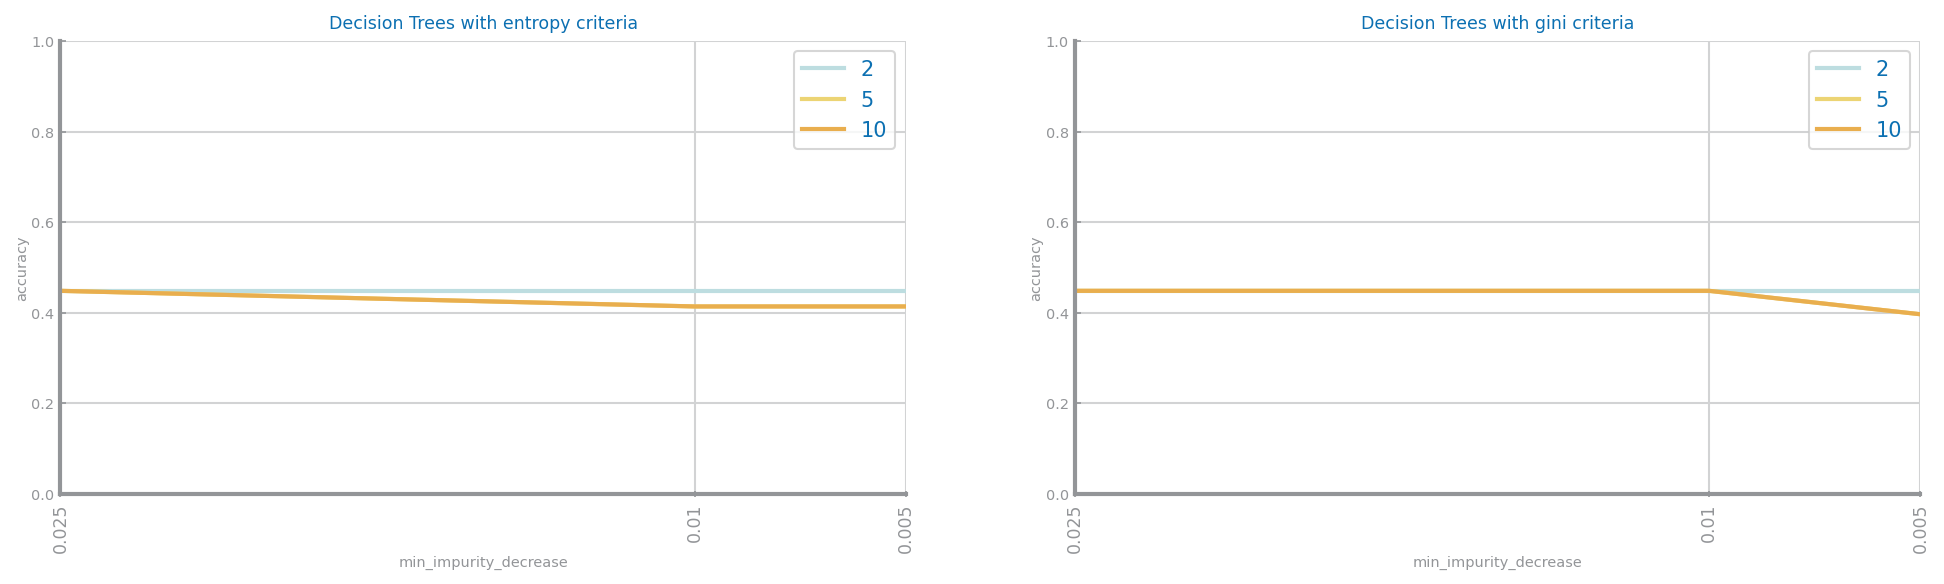

Best results achieved with entropy criteria, depth=2 and min_impurity_decrease=0.03 ==> accuracy=0.45


<Figure size 600x450 with 0 Axes>

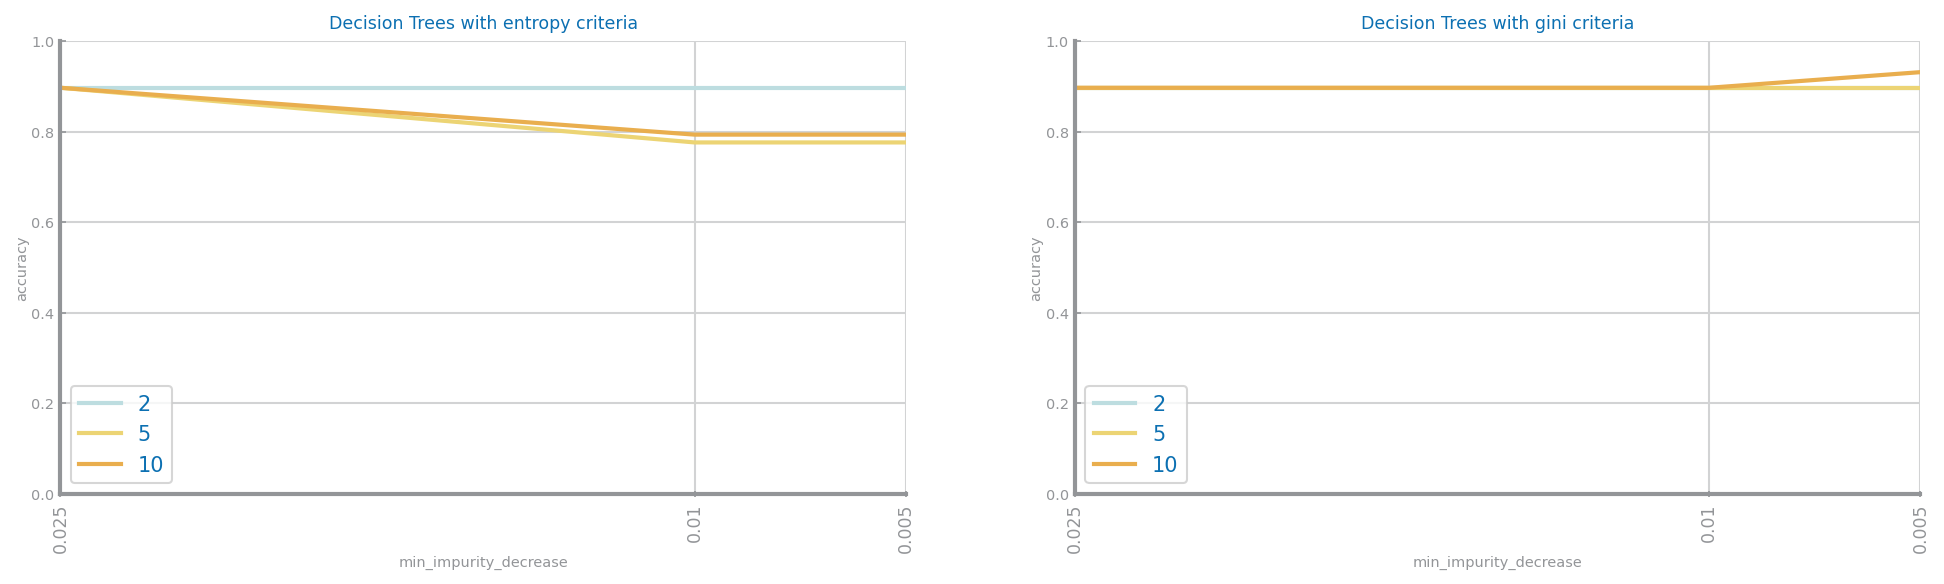

Best results achieved with gini criteria, depth=10 and min_impurity_decrease=0.01 ==> accuracy=0.93


<Figure size 600x450 with 0 Axes>

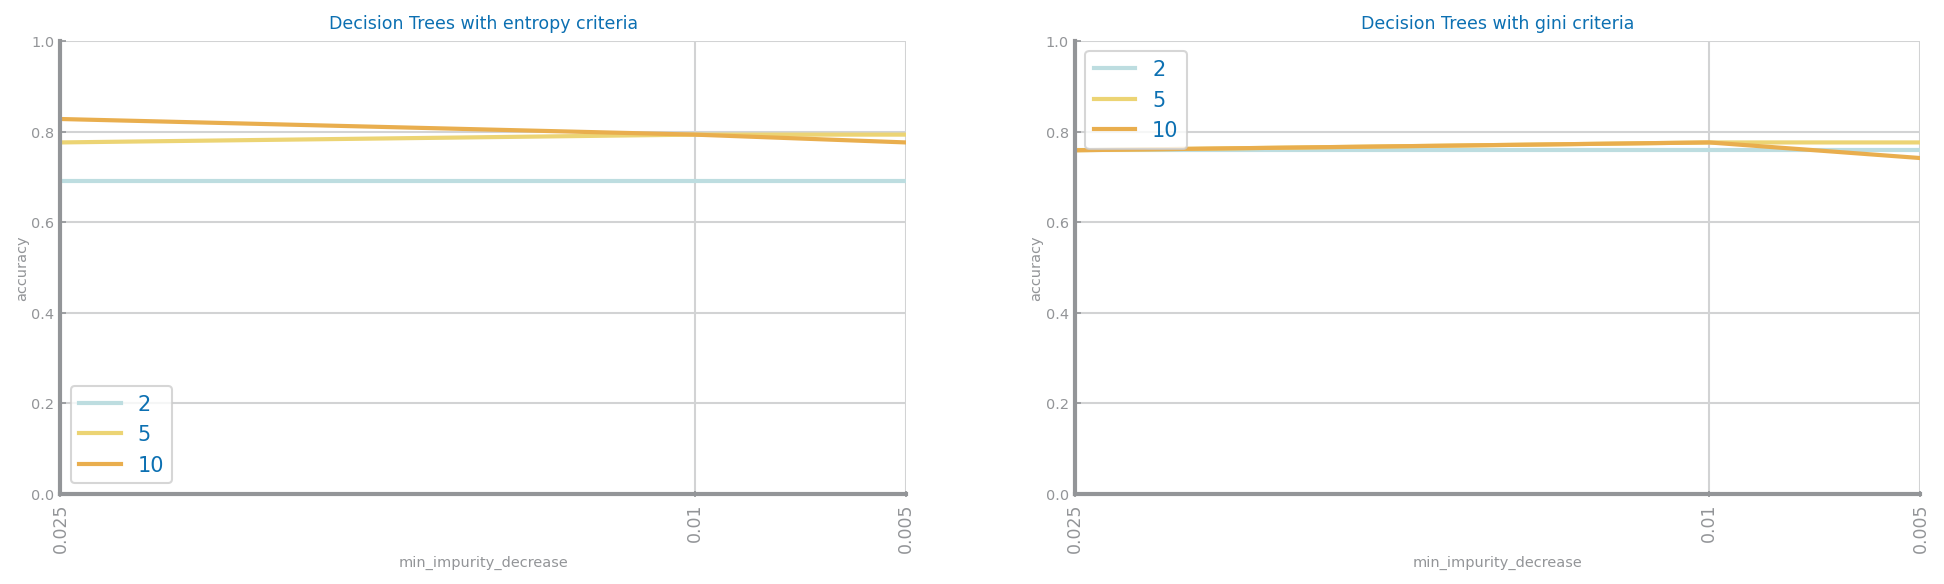

Best results achieved with entropy criteria, depth=10 and min_impurity_decrease=0.03 ==> accuracy=0.83


<Figure size 600x450 with 0 Axes>

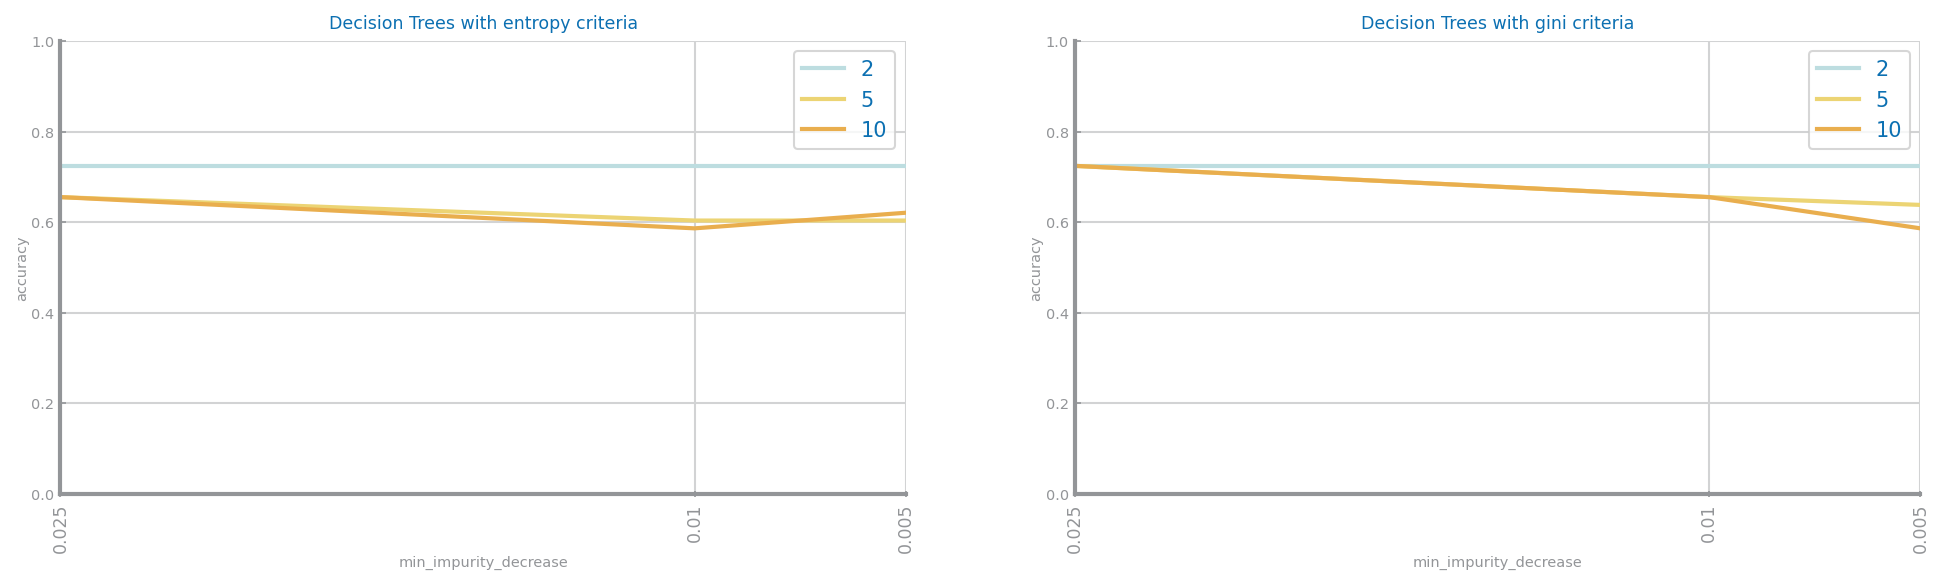

Best results achieved with entropy criteria, depth=2 and min_impurity_decrease=0.03 ==> accuracy=0.72


<Figure size 600x450 with 0 Axes>

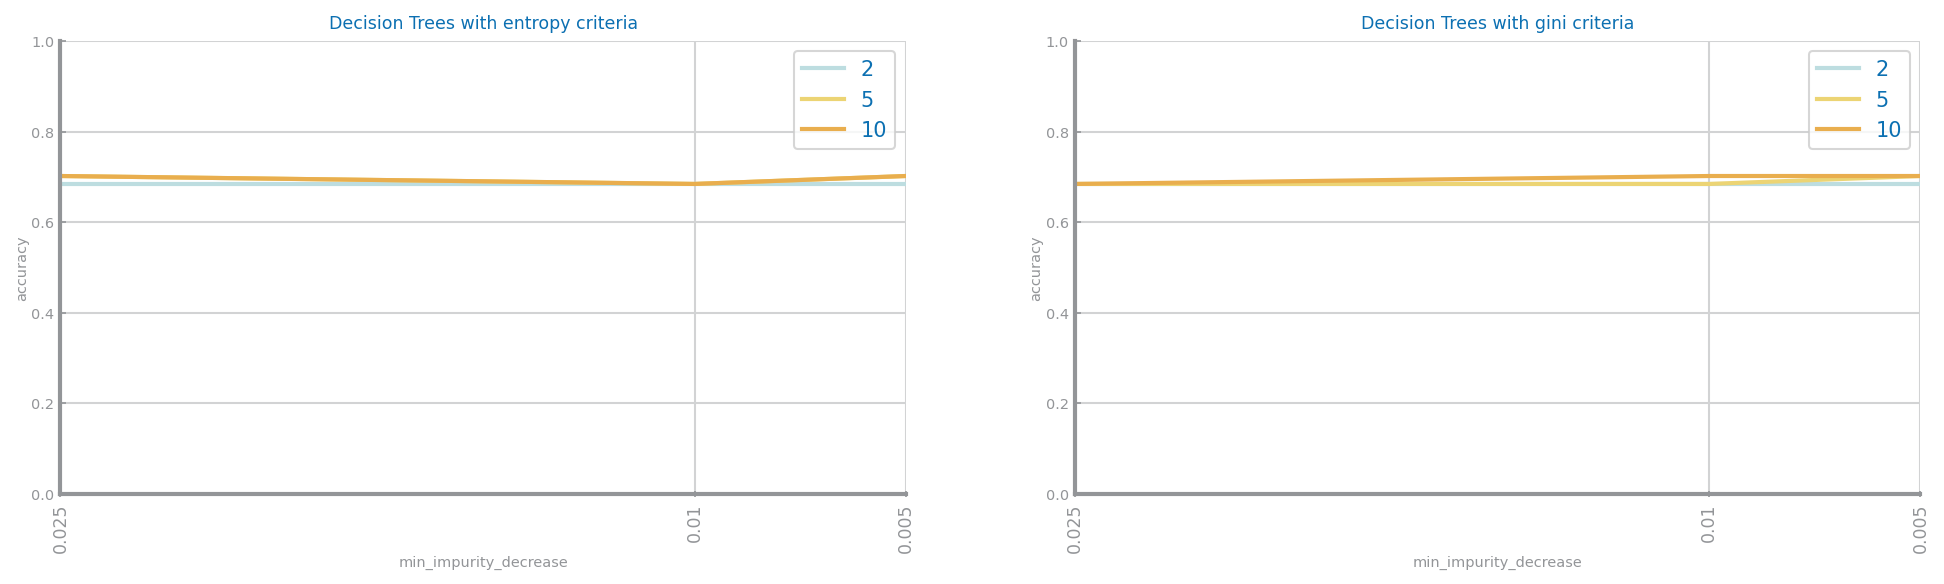

Best results achieved with entropy criteria, depth=5 and min_impurity_decrease=0.03 ==> accuracy=0.70
Confusion Matrix Test
TruePositives:  1
FalsePositives:  0
TrueNegatives:  39
FalseNegatives:  17


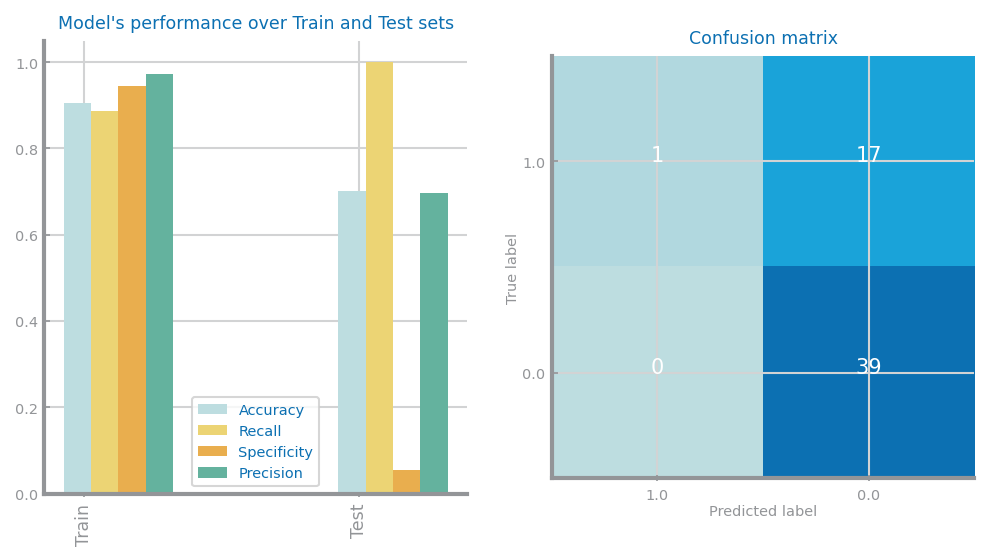

In [106]:
decision_tree_kfold(selected_features, num_splits_kfold=5, data=norm_data_minmax_clean, n=3, stratified=True)

In [ ]:
decision_tree_kfold(selected_features,num_splits_kfold=5, data=norm_data_minmax_clean, n=3, stratified=False)

### Without anaemia

In [ ]:
selected_features.pop("anaemia")
# selected_features.pop("diabetes")
selected_features

In [ ]:
decision_tree_kfold(selected_features,num_splits_kfold=5, data=norm_data_minmax_clean, n=3, stratified=False)

In [ ]:
selected_features.pop("diabetes")
selected_features

In [ ]:
decision_tree_kfold(selected_features,num_splits_kfold=5, data=norm_data_minmax_clean, n=3, stratified=False)